In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0501test_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

def test_model(model, image_processor, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # load the model weight which is the best and saved during training process
    model.load_state_dict(torch.load('weights_only_segformer\segformer_data_size_5.pth'))
    model.to(device)
    model.eval()

    total_loss = 0.0
    with torch.no_grad():
        for image, mask in test_loader:
            image, mask = image.to(device), mask.to(device)
            inputs = image_processor(images=image, return_tensors="pt").to(device)
            outputs = model(**inputs).logits
            outputs = F.interpolate(outputs, size=mask.size()[2:], mode='bilinear', align_corners=False)

            loss = criterion(outputs, mask)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Average test loss: {avg_loss}")
    return avg_loss

def showSegmentationResult(model, test_loader, num_images=1):
    plt.figure(figsize=(16, num_images * 5))
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for idx, (image, mask) in enumerate(test_loader):
        if idx >= num_images:
            break
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        labels = torch.squeeze(torch.argmax(outputs['out'].cpu(), dim=1)).numpy()

        # Original Image
        plt.subplot(num_images, 4, idx * 4 + 1)
        plt.imshow(np.transpose(torch.squeeze(image).cpu().numpy(), (1, 2, 0)))
        plt.axis(False)
        plt.title('Original Image')

        # Ground Truth Label
        plt.subplot(num_images, 4, idx * 4 + 2)
        plt.imshow(mask[:,0,:,:].permute(1, 2, 0).cpu().numpy())
        plt.axis(False)
        plt.title('Ground Truth Label')
        
        # Model Prediction
        plt.subplot(num_images, 4, idx * 4 + 3)
        plt.imshow(labels)
        plt.axis(False)
        plt.title('Model Prediction')

        # Overlay Prediction on Original Image
        plt.subplot(num_images, 4, idx * 4 + 4)
        overlay = image.cpu().squeeze().permute(1, 2, 0).numpy()
        red_channel = overlay[:, :, 0]
        red_channel[labels == 1] = 255  # 將預測為1的區域設為紅色
        overlay[:, :, 0] = red_channel
        plt.imshow(overlay)
        plt.axis(False)
        plt.title('Overlay Prediction on Original Image')

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 11s 863ms/step - loss: 0.6635
Average validation loss: 0.6351498961448669
4/4 [==============================] - 11s 885ms/step - loss: 0.6635 - val_loss: 0.6351
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_0\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 14s 783ms/step - loss: 0.5096 - val_loss: 0.6351
Average validation loss: 0.4889675974845886
4/4 [==============================] - 14s 798ms/step - loss: 0.5096 - val_loss: 0.5621
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_0\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 18s 785ms/step - loss: 0.4015 - val_loss: 0.5621
Average validation loss: 0.5464603900909424
4/4 [==============================] - 18s 798ms/step - loss: 0.4015 - val_loss: 0.5569
Epoch 4/10
4/4 [==============================] - 21s 770ms/s

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 723ms/step - loss: 0.0348
Average validation loss: 0.0
8/8 [==============================] - 6s 736ms/step - loss: 0.0348 - val_loss: 0.0000e+00
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_0\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 12s 714ms/step - loss: 0.0334 - val_loss: 0.0000e+00
Average validation loss: 3.8562003590314475e-09
8/8 [==============================] - 12s 727ms/step - loss: 0.0334 - val_loss: 1.9281e-09
Epoch 3/10
8/8 [==============================] - 18s 714ms/step - loss: 0.0327 - val_loss: 1.9281e-09
Average validation loss: 1.0706758502010416e-07
8/8 [==============================] - 18s 726ms/step - loss: 0.0327 - val_loss: 3.6975e-08
Epoch 4/10
8/8 [==============================] - 23s 710ms/step - loss: 0.0321 - val_loss: 3.6975e-08
Average validation loss: 1.9541984670468082e-06
8/8 [==============================]

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 709ms/step - loss: 0.0422
Average validation loss: 0.10437495509783427
12/12 [==============================] - 9s 723ms/step - loss: 0.0422 - val_loss: 0.1044
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_0\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 17s 717ms/step - loss: 0.0396 - val_loss: 0.1044
Average validation loss: 0.10528017083803813
12/12 [==============================] - 18s 729ms/step - loss: 0.0396 - val_loss: 0.1048
Epoch 3/10
12/12 [==============================] - 26s 713ms/step - loss: 0.0391 - val_loss: 0.1048
Average validation loss: 0.32277387419355813
12/12 [==============================] - 26s 726ms/step - loss: 0.0391 - val_loss: 0.1775
Epoch 4/10
12/12 [==============================] - 35s 712ms/step - loss: 0.0391 - val_loss: 0.1775
Average validation loss: 0.2994311253229777
12/12 [==============================] -

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 11s 715ms/step - loss: 0.0286
Average validation loss: 0.2896202998702687
16/16 [==============================] - 12s 727ms/step - loss: 0.0286 - val_loss: 0.2896
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_0\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 715ms/step - loss: 0.0281 - val_loss: 0.2896
Average validation loss: 0.09345533867210065
16/16 [==============================] - 23s 728ms/step - loss: 0.0281 - val_loss: 0.1915
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_0\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 35s 712ms/step - loss: 0.0284 - val_loss: 0.1915
Average validation loss: 0.02343781036324799
16/16 [==============================] - 35s 725ms/step - loss: 0.0284 - val_loss: 0.1355
Saved model weights to 'c:\Users\user\Desktop

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 15s 721ms/step - loss: 0.0183
Average validation loss: 0.02037775197532028
20/20 [==============================] - 15s 732ms/step - loss: 0.0183 - val_loss: 0.0204
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_0\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 715ms/step - loss: 0.0179 - val_loss: 0.0204
Average validation loss: 0.029016800969839097
20/20 [==============================] - 29s 726ms/step - loss: 0.0179 - val_loss: 0.0247
Epoch 3/10
20/20 [==============================] - 44s 712ms/step - loss: 0.0177 - val_loss: 0.0247
Average validation loss: 0.021574299350868388
20/20 [==============================] - 44s 724ms/step - loss: 0.0177 - val_loss: 0.0237
Epoch 4/10
20/20 [==============================] - 58s 715ms/step - loss: 0.0171 - val_loss: 0.0237
Average validation loss: 0.041375177140162124
20/20 [===========================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 717ms/step - loss: 0.0178
Average validation loss: 0.023611247073858976
24/24 [==============================] - 17s 728ms/step - loss: 0.0178 - val_loss: 0.0236
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_0\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 716ms/step - loss: 0.0168 - val_loss: 0.0236
Average validation loss: 0.02444726259758075
24/24 [==============================] - 35s 728ms/step - loss: 0.0168 - val_loss: 0.0240
Epoch 3/10
24/24 [==============================] - 52s 706ms/step - loss: 0.0162 - val_loss: 0.0240
Average validation loss: 0.026992904487997293
24/24 [==============================] - 52s 718ms/step - loss: 0.0162 - val_loss: 0.0250
Epoch 4/10
24/24 [==============================] - 69s 712ms/step - loss: 0.0156 - val_loss: 0.0250
Average validation loss: 0.016799993347376585
24/24 [===========================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 29s 715ms/step - loss: 0.0271
Average validation loss: 0.0388070272281766
40/40 [==============================] - 29s 726ms/step - loss: 0.0271 - val_loss: 0.0388
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_0\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 58s 713ms/step - loss: 0.0252 - val_loss: 0.0388
Average validation loss: 0.028014888986945152
40/40 [==============================] - 58s 724ms/step - loss: 0.0252 - val_loss: 0.0334
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_0\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 87s 713ms/step - loss: 0.0235 - val_loss: 0.0334
Average validation loss: 0.034207087196409705
40/40 [==============================] - 87s 725ms/step - loss: 0.0235 - val_loss: 0.0337
Epoch 4/10
40/40 [=========================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 34s 712ms/step - loss: 0.0191
Average validation loss: 0.07017334985236327
48/48 [==============================] - 35s 723ms/step - loss: 0.0191 - val_loss: 0.0702
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_0\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 69s 714ms/step - loss: 0.0175 - val_loss: 0.0702
Average validation loss: 0.013827163900103301
48/48 [==============================] - 70s 725ms/step - loss: 0.0175 - val_loss: 0.0420
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_0\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 104s 711ms/step - loss: 0.0155 - val_loss: 0.0420
Average validation loss: 0.01786239348196735
48/48 [==============================] - 104s 722ms/step - loss: 0.0155 - val_loss: 0.0340
Epoch 4/10
48/48 [=======================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 40s 714ms/step - loss: 0.0269
Average validation loss: 0.018390507603596364
56/56 [==============================] - 41s 726ms/step - loss: 0.0269 - val_loss: 0.0184
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_0\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 81s 713ms/step - loss: 0.0195 - val_loss: 0.0184
Average validation loss: 0.01232791459838735
56/56 [==============================] - 81s 724ms/step - loss: 0.0195 - val_loss: 0.0154
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_0\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 121s 714ms/step - loss: 0.0166 - val_loss: 0.0154
Average validation loss: 0.013392694381942809
56/56 [==============================] - 122s 725ms/step - loss: 0.0166 - val_loss: 0.0147
Epoch 4/10
56/56 [======================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 46s 712ms/step - loss: 0.0138
Average validation loss: 0.19780553877353668
64/64 [==============================] - 46s 724ms/step - loss: 0.0138 - val_loss: 0.1978
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_0\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 92s 712ms/step - loss: 0.0113 - val_loss: 0.1978
Average validation loss: 0.008527854559361003
64/64 [==============================] - 93s 724ms/step - loss: 0.0113 - val_loss: 0.1032
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_0\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 138s 711ms/step - loss: 0.0097 - val_loss: 0.1032
Average validation loss: 0.038660948688630015
64/64 [==============================] - 139s 723ms/step - loss: 0.0097 - val_loss: 0.0817
Epoch 4/10
64/64 [======================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 56s 779ms/step - loss: 0.0123
Average validation loss: 0.021034108112669654
72/72 [==============================] - 57s 791ms/step - loss: 0.0123 - val_loss: 0.0210
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_0\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 113s 781ms/step - loss: 0.0101 - val_loss: 0.0210
Average validation loss: 0.04635862085140414
72/72 [==============================] - 114s 793ms/step - loss: 0.0101 - val_loss: 0.0337
Epoch 3/10
72/72 [==============================] - 170s 778ms/step - loss: 0.0090 - val_loss: 0.0337
Average validation loss: 0.04035051456756062
72/72 [==============================] - 171s 790ms/step - loss: 0.0090 - val_loss: 0.0359
Epoch 4/10
72/72 [==============================] - 227s 777ms/step - loss: 0.0081 - val_loss: 0.0359
Average validation loss: 0.012076730982193517
72/72 [=======================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 63s 783ms/step - loss: 0.0120
Average validation loss: 0.007318797137122602
80/80 [==============================] - 64s 796ms/step - loss: 0.0120 - val_loss: 0.0073
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_0\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 126s 781ms/step - loss: 0.0098 - val_loss: 0.0073
Average validation loss: 0.006702565908199176
80/80 [==============================] - 127s 794ms/step - loss: 0.0098 - val_loss: 0.0070
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_0\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 190s 783ms/step - loss: 0.0085 - val_loss: 0.0070
Average validation loss: 0.007291976176202297
80/80 [==============================] - 191s 795ms/step - loss: 0.0085 - val_loss: 0.0071
Epoch 4/10
80/80 [=================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 69s 713ms/step - loss: 0.0180
Average validation loss: 0.017370922617071
96/96 [==============================] - 70s 725ms/step - loss: 0.0180 - val_loss: 0.0174
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_0\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 138s 715ms/step - loss: 0.0139 - val_loss: 0.0174
Average validation loss: 0.022431965291616507
96/96 [==============================] - 140s 727ms/step - loss: 0.0139 - val_loss: 0.0199
Epoch 3/10
96/96 [==============================] - 209s 718ms/step - loss: 0.0116 - val_loss: 0.0199
Average validation loss: 0.019997111696284264
96/96 [==============================] - 210s 730ms/step - loss: 0.0116 - val_loss: 0.0199
Epoch 4/10
96/96 [==============================] - 279s 717ms/step - loss: 0.0102 - val_loss: 0.0199
Average validation loss: 0.023132382242086653
96/96 [=======================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 86s 717ms/step - loss: 0.0129
Average validation loss: 0.006571333288835982
120/120 [==============================] - 87s 729ms/step - loss: 0.0129 - val_loss: 0.0066
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_0\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 174s 718ms/step - loss: 0.0107 - val_loss: 0.0066
Average validation loss: 0.008769520612743994
120/120 [==============================] - 175s 730ms/step - loss: 0.0107 - val_loss: 0.0077
Epoch 3/10
120/120 [==============================] - 261s 718ms/step - loss: 0.0094 - val_loss: 0.0077
Average validation loss: 0.006542780483141541
120/120 [==============================] - 263s 729ms/step - loss: 0.0094 - val_loss: 0.0073
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_0\segformer_data_size_150.pth'.
Epoch 4/10
120/120 [===

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 103s 719ms/step - loss: 0.0099
Average validation loss: 0.025990142891209364
144/144 [==============================] - 105s 730ms/step - loss: 0.0099 - val_loss: 0.0260
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_0\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 208s 714ms/step - loss: 0.0088 - val_loss: 0.0260
Average validation loss: 0.009827233728073124
144/144 [==============================] - 210s 725ms/step - loss: 0.0088 - val_loss: 0.0179
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_0\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 312s 713ms/step - loss: 0.0074 - val_loss: 0.0179
Average validation loss: 0.01233928219234157
144/144 [==============================] - 314s 724ms/step - loss: 0.0074 - val_loss: 0.0161
Epoch 4/10
144/144 [==

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 116s 722ms/step - loss: 0.0514
Average validation loss: 0.09092904916033148
160/160 [==============================] - 117s 733ms/step - loss: 0.0514 - val_loss: 0.0909
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_0\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 232s 718ms/step - loss: 0.0452 - val_loss: 0.0909
Average validation loss: 0.06163140586577356
160/160 [==============================] - 234s 729ms/step - loss: 0.0452 - val_loss: 0.0763
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_0\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 349s 716ms/step - loss: 0.0413 - val_loss: 0.0763
Average validation loss: 0.2948228464245403
160/160 [==============================] - 351s 727ms/step - loss: 0.0413 - val_loss: 0.1491
Epoch 4/10
160/160 [=====

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 143s 716ms/step - loss: 0.0146
Average validation loss: 0.009206426050513982
200/200 [==============================] - 145s 728ms/step - loss: 0.0146 - val_loss: 0.0092
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_0\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 290s 722ms/step - loss: 0.0126 - val_loss: 0.0092
Average validation loss: 0.008584586960350861
200/200 [==============================] - 292s 734ms/step - loss: 0.0126 - val_loss: 0.0089
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_0\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 436s 716ms/step - loss: 0.0108 - val_loss: 0.0089
Average validation loss: 0.008038541635032743
200/200 [==============================] - 438s 728ms/step - loss: 0.0108 - val_loss: 0.0086
Saved model weights t

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:51 - loss: 0.0028

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 172s 717ms/step - loss: 0.0097
Average validation loss: 0.0076955565683116825
240/240 [==============================] - 175s 729ms/step - loss: 0.0097 - val_loss: 0.0077
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_0\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 347s 716ms/step - loss: 0.0076 - val_loss: 0.0077
Average validation loss: 0.010496335315474425
240/240 [==============================] - 349s 727ms/step - loss: 0.0076 - val_loss: 0.0091
Epoch 3/10
240/240 [==============================] - 521s 716ms/step - loss: 0.0066 - val_loss: 0.0091
Average validation loss: 0.008702797115620341
240/240 [==============================] - 524s 728ms/step - loss: 0.0066 - val_loss: 0.0090
Epoch 4/10
240/240 [==============================] - 696s 715ms/step - loss: 0.0060 - val_loss: 0.0090
Average validation loss: 0.0128616158773184
240/240 [===

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.10359312230207479, 0.08803691690104444, 0.24742215681824387, 0.056058888296287614, 0.029941629842589346, 0.015384672051658128, 0.032693213316213714, 0.026172463126194145, 0.020224230747537857, 0.02776573774012519, 0.009513946892104193, 0.006906538707814547, 0.014691884985915447, 0.005153299848282623, 0.04355800300351111, 0.03207955330195544, 0.00569820212607815, 0.005089124241212899]
std_val_losses =  [0.17643437922604044, 0.07852727140114554, 0.2541431999427804, 0.05127395096510717, 0.03082780306620506, 0.008847506989003742, 0.03517215082070508, 0.05150738849433324, 0.04618983486651557, 0.04388759338416994, 0.00885986133845853, 0.0038265390697151814, 0.021388324379891657, 0.0018867694606230394, 0.174365955657694, 0.04690710649211079, 0.0031052673751186047, 0.00339157819538455]


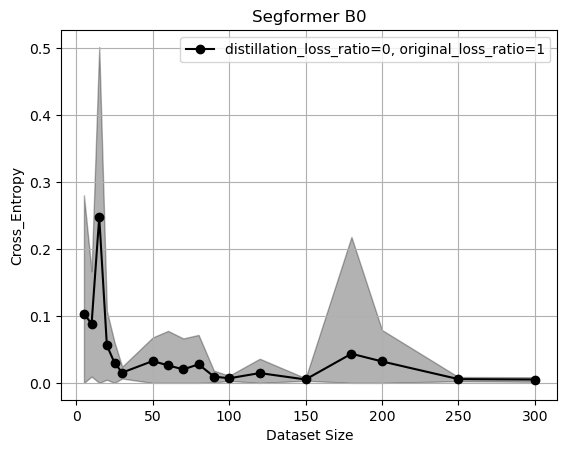

In [2]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()